In [1]:
from icecube import icetray, dataio, dataclasses, simclasses, clsim
from icecube.icetray import I3Units, OMKey, I3Frame
from icecube.dataclasses import ModuleKey
from os.path import expandvars
import scipy.constants as spc
import scipy as sc
import numpy as np
import matplotlib.pylab as plt

In [2]:
file = dataio.I3File('/data/p-one/akatil/step_3_medium_water/Custom/NuTau_NuE_20Events/step_3_713_medium_water_custom_mDOM.i3.gz')

In [3]:
gcd_file = dataio.I3File('/home/users/akatil/P-ONE/GCD_files/PONE_Phase1.i3.gz')
cframe = gcd_file.pop_frame()
geometry = cframe["I3Geometry"]
geoMap = geometry.omgeo
print('loaded geometry')

loaded geometry


In [4]:
maxMCPE_e = 0
maxMCPE_t = 0 

for frame in file:
    print('new Frame')
    mctree = frame["I3MCTree"]
    primary = mctree.primaries
    lepton = dataclasses.I3MCTree.first_child(mctree, primary[0].id)
    #tauDecayProd = dataclasses.I3MCTree.get_daughters(mctree, tau.id)
    #daughterTauPos = tau.pos
    #daughterTauEnergies = tau.energy

    mcpeMap = frame['MCPESeriesMap']

    print('Finding OM Positions and time residuals')


    for omkey in mcpeMap.keys():
        oKey = geoMap.get(omkey)
        domPos = oKey.position

        mcpeList = mcpeMap[omkey]
        timeList = [mcpe.time for mcpe in mcpeList]
        timeList = np.array(timeList)
        #timeRes = timeList - timeTaken
        if lepton.type == 11 or lepton.type == -11:
            if len(timeList) > maxMCPE_e and len(timeList) < 900:
                #print('-----TIME LIST ------', len(timeList))      #electron
                maxMCPE_e = len(timeList)
                timeArrival_e = timeList
        if lepton.type == 15 or lepton.type == -15:
            if len(timeList) > maxMCPE_t and len(timeList) < 900:
                #print('-----TIME LIST ------', len(timeList))      #tau
                maxMCPE_t = len(timeList) 
                timeArrival_t = timeList

new Frame
Finding OM Positions and time residuals
new Frame
Finding OM Positions and time residuals
new Frame
Finding OM Positions and time residuals
new Frame
Finding OM Positions and time residuals
new Frame
Finding OM Positions and time residuals
new Frame
Finding OM Positions and time residuals
new Frame
Finding OM Positions and time residuals
new Frame
Finding OM Positions and time residuals
new Frame
Finding OM Positions and time residuals
new Frame
Finding OM Positions and time residuals
new Frame
Finding OM Positions and time residuals
new Frame
Finding OM Positions and time residuals
new Frame
Finding OM Positions and time residuals
new Frame
Finding OM Positions and time residuals
new Frame
Finding OM Positions and time residuals
new Frame
Finding OM Positions and time residuals


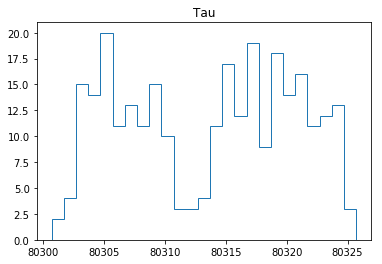

In [14]:
bins = np.arange(min(timeArrival_t), min(timeArrival_t)+26, 1)
num, bin_edges, _ = plt.hist(timeArrival_t, bins=bins, histtype='step')
plt.title('Tau')

In [15]:
import scipy

def gaussian(x, pos, wid, amp):
    y = amp*np.exp(-4*np.log(2)*((x-pos)/(wid))**2)
    return y

def BiGauss(x, pos, wid, r, amp):
    mask = x < pos
    
    y_all = ([])
    for i in range(0, len(mask)):
    
        if mask[i] == True:
            m = 1
            nm = 0
        else:
            m = 0
            nm = 1
        if r != 0:
            y1 = gaussian(x[i],pos,r*wid/(r+1),amp)*m
            y2 = gaussian(x[i],pos,wid/(r+1),amp)*nm
            y = y1 + y2
        else:
            y = gaussian(x[i],pos,wid)*nm
        
        y_all = np.append(y_all, y)
    return y_all
    
def double_peak(x, pos1, wid1, r1, amp1, pos2, wid2, r2, amp2):
    x1 = x[x <= min(x)+10]
    x2 = x[x > min(x)+10]
    b1 = BiGauss(x, pos1, wid1, r1, amp1)
    b2 = BiGauss(x, pos2, wid2, r2, amp2)
    b = np.append(b1, b2)
    return b1+b2

def log_likelihood(theta, n, x):
    #pos, wid, r, amp = theta
    pos1, wid1, r1, amp1, pos2, wid2, r2, amp2 = theta
    #model = BiGauss(x, pos, wid, r, amp)
    model = double_peak(x, pos1, wid1, r1, amp1, pos2, wid2, r2, amp2)
    L = np.log(scipy.special.factorial(n)) + model - (n*np.log(model))
    return np.sum(L)
    
'''
def log_likelihood(theta, x, y):
    pos, wid, amp, log_f = theta
    yerr = 0
    model = amp*np.exp(-4*np.log(2)*((x-pos)/(wid))**2)
    sigma2 = yerr ** 2 + model ** 2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))
'''

'\ndef log_likelihood(theta, x, y):\n    pos, wid, amp, log_f = theta\n    yerr = 0\n    model = amp*np.exp(-4*np.log(2)*((x-pos)/(wid))**2)\n    sigma2 = yerr ** 2 + model ** 2 * np.exp(2 * log_f)\n    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))\n'

In [16]:
from scipy.optimize import minimize

nll = lambda *args: -log_likelihood(*args)
bin_centers = (bin_edges[:-1]+bin_edges[1:])/2
#initial = np.array([bin_centers[num == max(num)], 5, 0.1, max(num)])
initial = np.array([min(bin_centers), 5, 0.1, max(num), min(bin_centers)+30, 5, 0.1, max(num)])
#bnds = ((min(bin_centers), min(bin_centers)+5), (0, 10), (0, max(num)))
soln = minimize(log_likelihood, initial, args=(num, bin_centers), method='Powell')

In [17]:
x = np.linspace(min(bin_centers)-10, max(bin_centers)+10, 1000)
#y = BiGauss(x, soln.x[0], soln.x[1], soln.x[2], soln.x[3])
y = double_peak(x, soln.x[0], soln.x[1], soln.x[2], soln.x[3], soln.x[4], soln.x[5], soln.x[6], soln.x[7])

In [18]:
soln

   direc: array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 1.90030463e-01,  7.66347391e-02,  3.95924947e-02,
         5.26174910e-02,  2.02268729e-02,  1.13500939e-02,
        -1.46364193e-03, -8.92268149e-02],
       [-1.32572373e-02, -2.82801017e+00,  1.18330235e-02,
         5.96428713e-01, -9.79753298e-02, -3.80089309e-02,
        -1.90623817e-02,  8.26606228e-01],
       [-1.28852882e-01, -6.80884286e-01, -4.15789873e-04,
        -4.22959071e-01, -4.68120156e+00, -2.80678103e+00,
         1.57154599e-02,  2.48309806e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-2.62101331e-01,  1.50925089e+00, -2.88259564e-03,
        -2.57057076e+00, -4.02267088e+00,  5.35452624e-01,
        -3.50036695e-02, -3.95235233e+00],
       [ 0.00000000e+00,

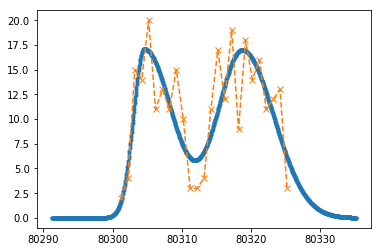

In [19]:
plt.plot(x, y, '.')
plt.plot(bin_centers, num, '--x')

In [358]:
popt, pcov = scipy.optimize.curve_fit(gaussian, xdata=bin_centers, ydata=num,
                                      p0 = (41194018.90347786+10, 10, 200), absolute_sigma=True)

In [359]:
bin_centers[num == max(num)]

array([41194018.90347786])

In [360]:
popt

array([4.11940192e+07, 8.36489509e+00, 6.16024090e+01])

In [212]:
x1 = np.linspace(min(bin_centers)-10, max(bin_centers)+10, 1000)
y1 = gaussian(x, popt[0], popt[1], popt[2])

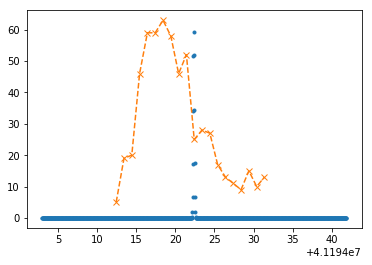

In [213]:
plt.plot(x1, y1, '.')
plt.plot(bin_edges[:-1], num, '--x')

In [16]:
sc.signal.find_peaks_cwt?

In [18]:
timeArrival_t[173]

80313.08465242606